# FSD audio classification

## Setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [44]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

from fastai.vision import *
from fastai.metrics import accuracy

device = torch.device('cuda')

np.random.seed(12)

## Data

In [3]:
PATH = Path('data/FSDKaggle2018')

labels_train = pd.read_csv(list(iter((PATH/'meta').glob('*')))[1])
labels_test = pd.read_csv(list(iter((PATH/'meta').glob('*')))[0])

len(list(iter((PATH/'audio_train').glob('*')))), len(list(iter((PATH/'audio_test').glob('*'))))

(9473, 1600)

In [4]:
labels_train.head()

,fname,label,manually_verified,freesound_id,license
0,00044347.wav,Hi-hat,0,28739,Attribution
1,001ca53d.wav,Saxophone,1,358827,Attribution
2,002d256b.wav,Trumpet,0,10897,Creative Commons 0
3,0033e230.wav,Glockenspiel,1,325017,Attribution
4,00353774.wav,Cello,1,195688,Attribution


In [10]:
labels_train['img_fname'] = labels_train['fname'].map(lambda x: x.split('.')[0] + '.png')

In [68]:
data = (ImageList.from_df(labels_train, path='', cols='img_fname', folder=PATH/'imgs_train')
        .use_partial_data(1.)
        .split_by_rand_pct(0.2, seed=1)
        .label_from_df('label')
        .transform(None, size=224)
        .databunch(bs=64, device=device, num_workers=0))

In [71]:
len(data.classes)

41

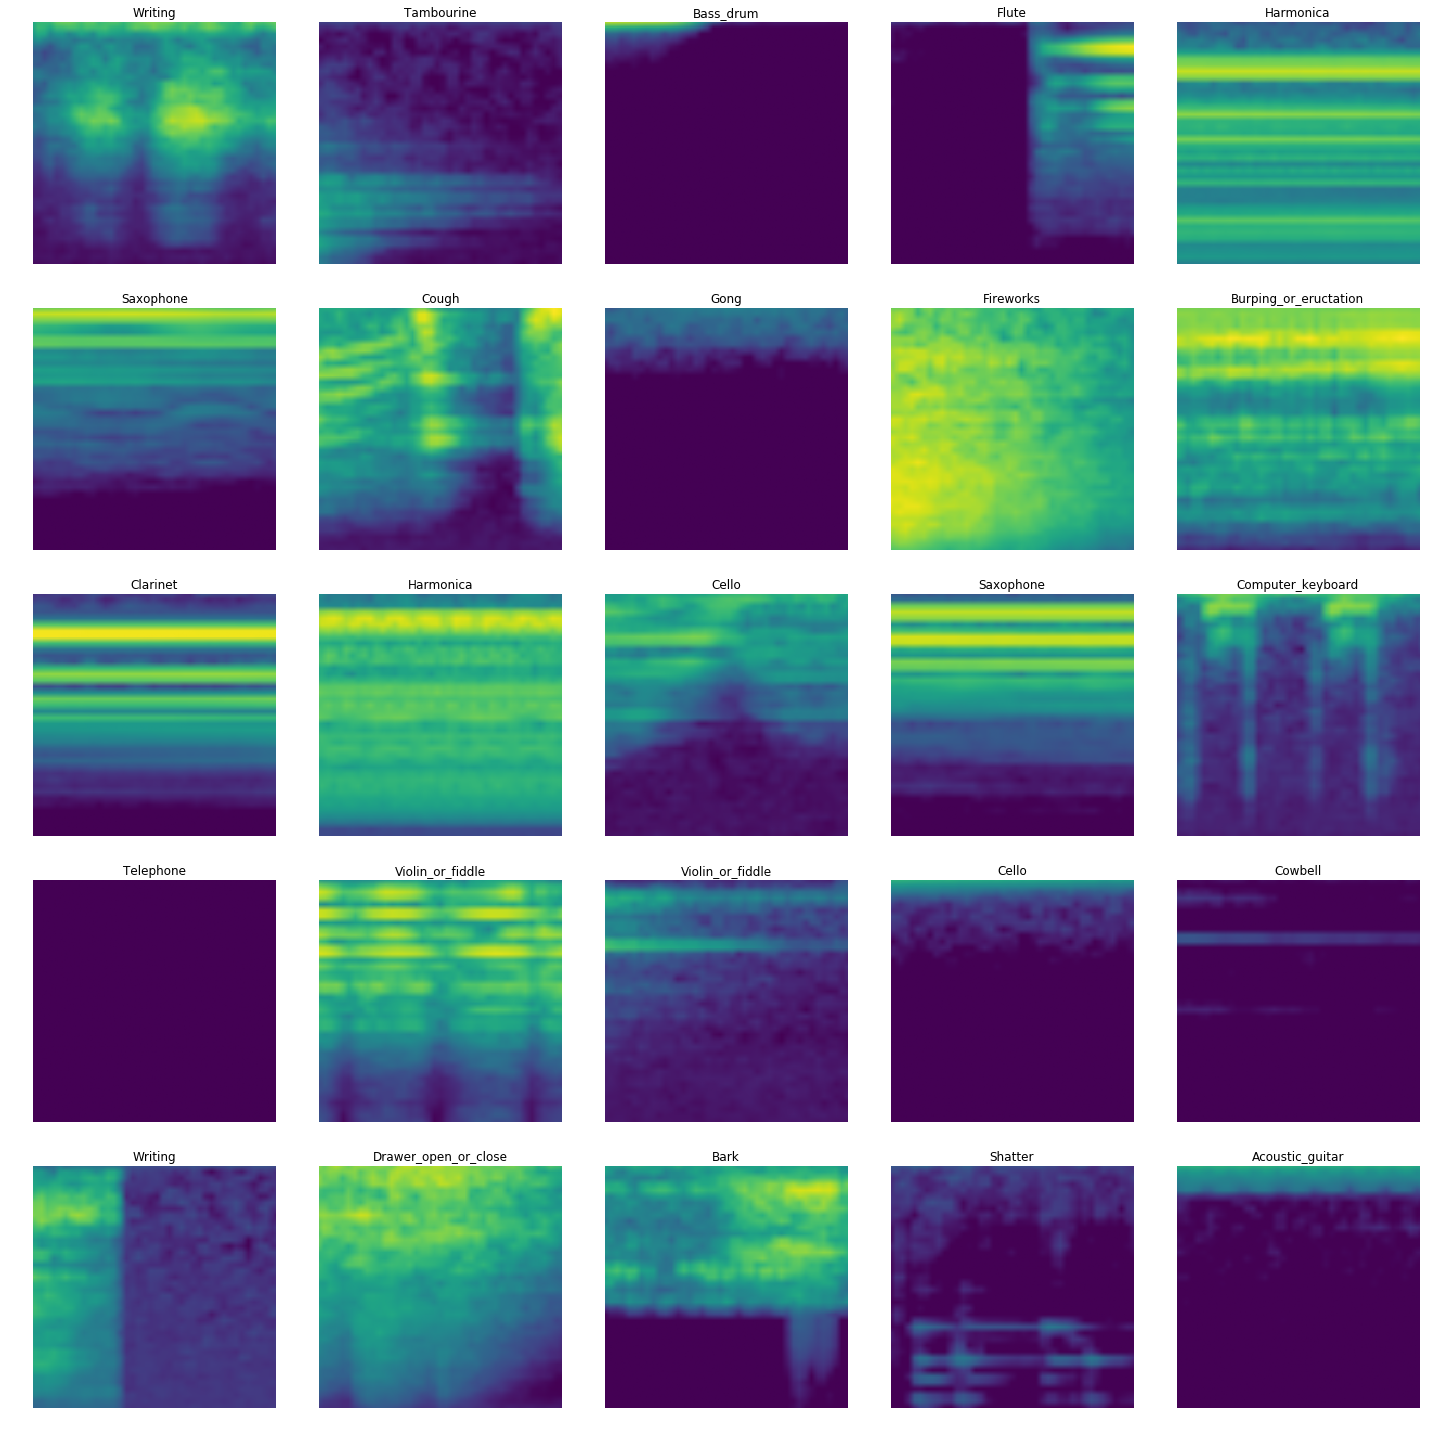

In [53]:
data.show_batch()

We can already see that we're going to have some difficulties in terms of image size - some of the cropping has left silent parts of the signal. Let's try it as a baseline anyway.

## Learner

In [69]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


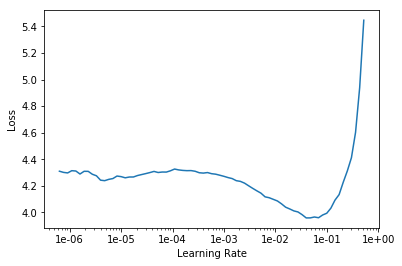

In [43]:
learn.lr_find()
learn.recorder.plot()

In [70]:
learn.fit_one_cycle(5, slice(2e-2))

epoch,train_loss,valid_loss,accuracy,time
0,2.802975,2.546652,0.350581,11:55
1,2.461369,2.222790,0.389652,11:52
2,2.040300,1.967405,0.458289,12:04
3,1.681438,1.795882,0.502112,12:02
4,1.416393,1.775864,0.515312,11:57


In [72]:
learn.save('fsd0-stage-0')

In [75]:
interp = ClassificationInterpretation.from_learner(learn)

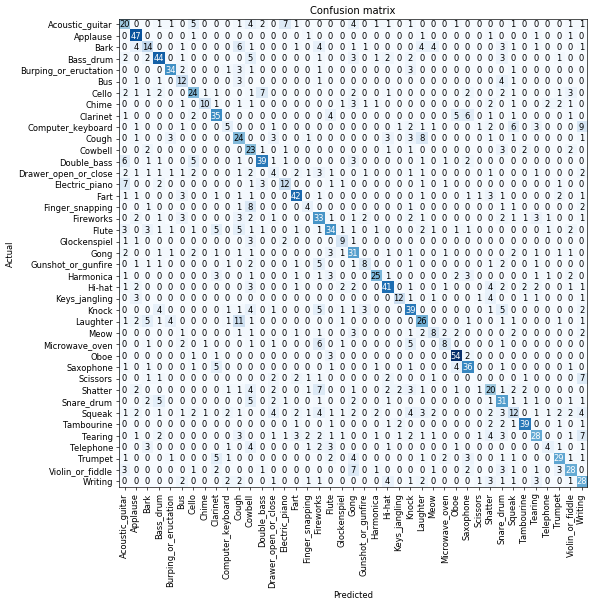

In [76]:
interp.plot_confusion_matrix(figsize=(10, 10), dpi=60)

In [78]:
interp.most_confused(min_val=5)

[('Laughter', 'Cough', 11),
 ('Computer_keyboard', 'Writing', 9),
 ('Cough', 'Laughter', 8),
 ('Finger_snapping', 'Cowbell', 8),
 ('Acoustic_guitar', 'Electric_piano', 7),
 ('Cello', 'Double_bass', 7),
 ('Electric_piano', 'Acoustic_guitar', 7),
 ('Scissors', 'Writing', 7),
 ('Shatter', 'Fireworks', 7),
 ('Tearing', 'Writing', 7),
 ('Violin_or_fiddle', 'Gong', 7),
 ('Bark', 'Cough', 6),
 ('Clarinet', 'Saxophone', 6),
 ('Computer_keyboard', 'Squeak', 6),
 ('Double_bass', 'Acoustic_guitar', 6),
 ('Microwave_oven', 'Fireworks', 6),
 ('Acoustic_guitar', 'Cello', 5),
 ('Bass_drum', 'Cowbell', 5),
 ('Clarinet', 'Oboe', 5),
 ('Double_bass', 'Cello', 5),
 ('Flute', 'Clarinet', 5),
 ('Flute', 'Cough', 5),
 ('Gunshot_or_gunfire', 'Fireworks', 5),
 ('Knock', 'Fireworks', 5),
 ('Knock', 'Snare_drum', 5),
 ('Laughter', 'Bark', 5),
 ('Microwave_oven', 'Knock', 5),
 ('Saxophone', 'Clarinet', 5),
 ('Snare_drum', 'Bass_drum', 5),
 ('Snare_drum', 'Cowbell', 5),
 ('Trumpet', 'Clarinet', 5)]